# Jacobi Solver sanity check

In [1]:
import numpy as np
from time import time
from numpy.linalg import norm
from naviflow_oo.solver.pressure_solver.helpers.rhs_construction import get_rhs
from naviflow_oo.solver.pressure_solver.helpers.matrix_free import compute_Ap_product
from naviflow_oo.preprocessing.mesh.structured import StructuredMesh


print(f"Loading arrays for pressure solving")
u_star = np.load('arrays_35x35/u_star.npy')
v_star = np.load('arrays_35x35/v_star.npy')
d_u = np.load('arrays_35x35/d_u.npy')
d_v = np.load('arrays_35x35/d_v.npy')
p_star = np.load('arrays_35x35/p_star.npy')
p_prime = np.load('arrays_35x35/p_prime.npy')
print(f"u_star shape: {u_star.shape}")
print(f"v_star shape: {v_star.shape}")
print(f"d_u shape: {d_u.shape}")
print(f"d_v shape: {d_v.shape}")
print(f"p_star shape: {p_star.shape}")
print(f"p_prime shape: {p_prime.shape}")

Loading arrays for pressure solving
u_star shape: (36, 35)
v_star shape: (35, 36)
d_u shape: (36, 35)
d_v shape: (35, 36)
p_star shape: (35, 35)
p_prime shape: (35, 35)


In [2]:
# Create mesh and setup
nx, ny = 35, 35 
mesh = StructuredMesh(nx=nx, ny=ny, length=1.0, height=1.0)
dx, dy = mesh.get_cell_sizes()
F = get_rhs(mesh.nx, mesh.ny, mesh.dx, mesh.dy, 1.0, u_star, v_star)

In [3]:
# Set parameters for Jacobi solver
omega = 0.9 
max_iterations = 1000

In [4]:

# Import the Jacobi solver
from naviflow_oo.solver.pressure_solver.jacobi import JacobiSolver

# Create Jacobi solver instance
jacobi_solver = JacobiSolver(omega=omega, max_iterations=max_iterations, tolerance=1e-20)

# Initial guess (zeros)
u_jacobi = np.zeros((mesh.nx, mesh.ny))  # Start with 2D array of zeros

# Run Jacobi solver and track convergence
residuals = []
errors_2 = []
errors_inf = []
# Calculate initial error
initial_error = norm((p_prime - u_jacobi).flatten(), np.inf) / norm(p_prime.flatten(), np.inf)
initial_error_2 = norm((p_prime - u_jacobi).flatten(), 2) / norm(p_prime.flatten(), 2)
errors_2.append(initial_error_2)
errors_inf.append(initial_error)

print(f"Initial error (relative to benchmark): {initial_error:.6e}")



Initial error (relative to benchmark): 1.000000e+00


In [5]:

# Apply Jacobi iterations using the main solver
for i in range(1, max_iterations+1):  # Run in groups of 5 iterations for speed
    # Apply 5 iterations of the improved Jacobi method
    u_jacobi = jacobi_solver.solve(
        p=u_jacobi,            
        b=F,                    
        nx=mesh.nx,             
        ny=mesh.ny,             
        dx=dx,                  
        dy=dy,                  
        rho=1.0,                
        d_u=d_u,                
        d_v=d_v,                
        num_iterations=1,       
        track_residuals=False   
    )
    
    # Calculate residual 
    u_jacobi_flat = u_jacobi.flatten('F')
    r = F - compute_Ap_product(u_jacobi_flat, mesh.nx, mesh.ny, dx, dy, 1.0, d_u, d_v)
    res_norm =   norm(r, 2)/norm(F, 2)
    residuals.append(res_norm)
    
    # Calculate error directly
    error_2 = norm((p_prime - u_jacobi).flatten(), 2) / norm(p_prime.flatten(), 2)
    errors_2.append(error_2)
    error_inf = norm((p_prime - u_jacobi).flatten(), np.inf) / norm(p_prime.flatten(), np.inf)
    errors_inf.append(error_inf)
    

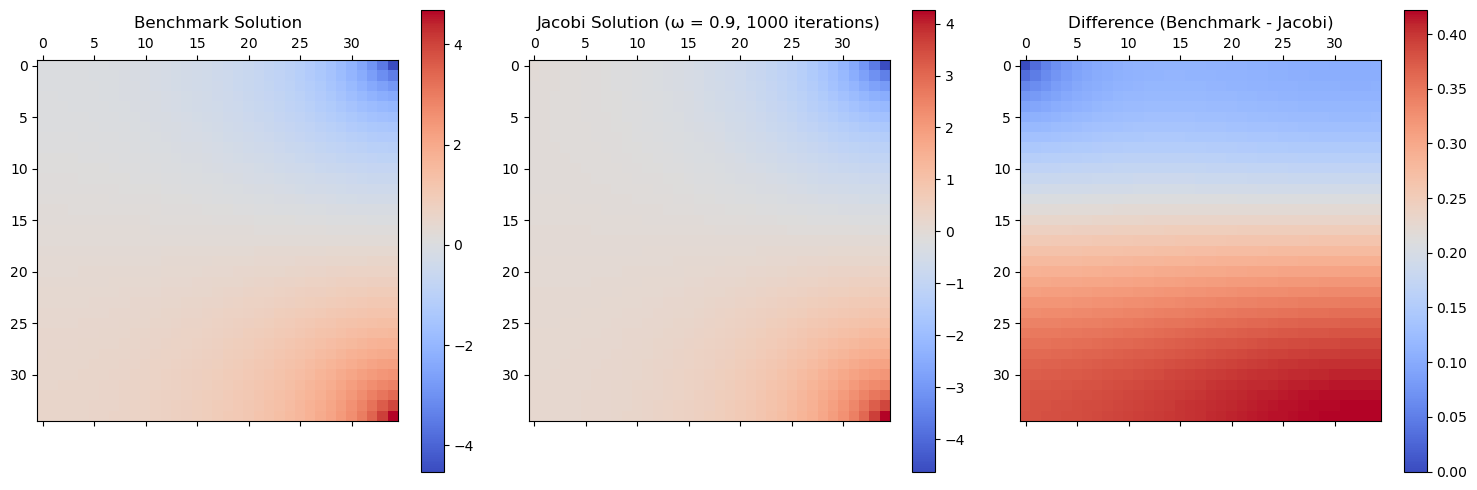

In [6]:
import matplotlib.pyplot as plt
import scienceplots


# Reshape solutions for plotting
p_prime_2d = p_prime.reshape((mesh.nx, mesh.ny))
u_jacobi_2d = u_jacobi.reshape((mesh.nx, mesh.ny))

# Compute the difference
diff = p_prime_2d - u_jacobi_2d

# Plot solutions side by side
plt.figure(figsize=(15, 5))

# Plot benchmark solution
plt.subplot(1, 3, 1)
im1 = plt.matshow(p_prime_2d, cmap='coolwarm', fignum=False)
plt.colorbar(im1)
plt.title('Benchmark Solution')

# Plot Jacobi solution
plt.subplot(1, 3, 2)
im2 = plt.matshow(u_jacobi_2d, cmap='coolwarm', fignum=False)
plt.colorbar(im2)
plt.title(f'Jacobi Solution (ω = {omega}, {max_iterations} iterations)')

# Plot difference
plt.subplot(1, 3, 3)
im3 = plt.matshow(diff, cmap='coolwarm', fignum=False)
plt.colorbar(im3)
plt.title('Difference (Benchmark - Jacobi)')

plt.tight_layout()
plt.show()

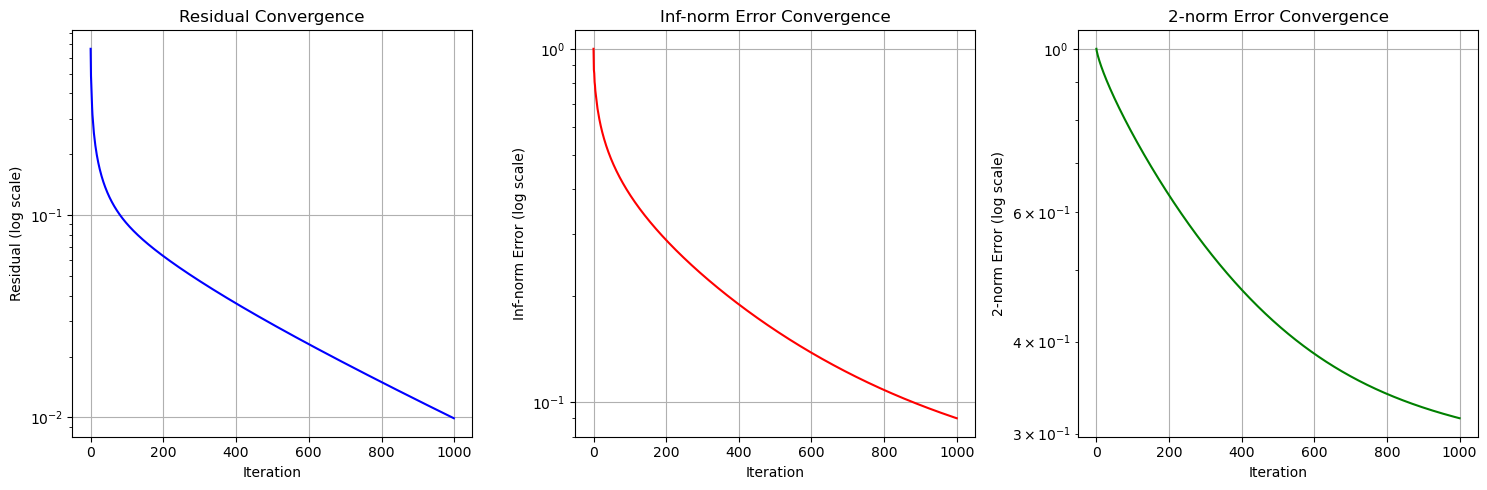

In [7]:
# Plot convergence history
plt.figure(figsize=(15, 5))

# Plot residual history
plt.subplot(1, 3, 1)
plt.semilogy(range(len(residuals)), residuals, 'b-')
plt.xlabel('Iteration')
plt.ylabel('Residual (log scale)')
plt.title('Residual Convergence')
plt.grid(True)

# Plot inf-norm error history
plt.subplot(1, 3, 2)
plt.semilogy(range(len(errors_inf)), errors_inf, 'r-')
plt.xlabel('Iteration')
plt.ylabel('Inf-norm Error (log scale)')
plt.title('Inf-norm Error Convergence')
plt.grid(True)

# Plot 2-norm error history
plt.subplot(1, 3, 3)
plt.semilogy(range(len(errors_2)), errors_2, 'g-')
plt.xlabel('Iteration')
plt.ylabel('2-norm Error (log scale)')
plt.title('2-norm Error Convergence')
plt.grid(True)

plt.tight_layout()

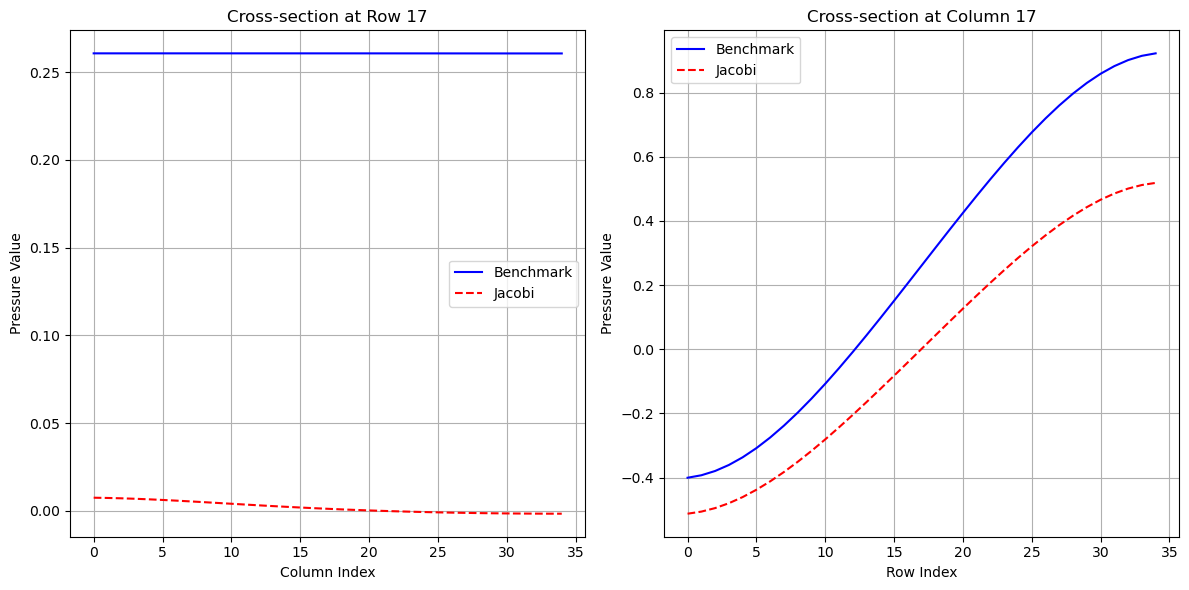

In [8]:

# Also create a cross-section plot to better visualize the differences
plt.figure(figsize=(12, 6))

# Plot cross-section at the middle row
mid_row = mesh.nx // 2
plt.subplot(1, 2, 1)
plt.plot(p_prime_2d[mid_row, :], 'b-', label='Benchmark')
plt.plot(u_jacobi_2d[mid_row, :], 'r--', label='Jacobi')
plt.title(f'Cross-section at Row {mid_row}')
plt.xlabel('Column Index')
plt.ylabel('Pressure Value')
plt.legend()
plt.grid(True)

# Plot cross-section at the middle column
mid_col = mesh.ny // 2
plt.subplot(1, 2, 2)
plt.plot(p_prime_2d[:, mid_col], 'b-', label='Benchmark')
plt.plot(u_jacobi_2d[:, mid_col], 'r--', label='Jacobi')
plt.title(f'Cross-section at Column {mid_col}')
plt.xlabel('Row Index')
plt.ylabel('Pressure Value')
plt.legend()
plt.grid(True)

plt.tight_layout()

In [9]:

print("\n====== Jacobi Benchmark Summary ======")
print(f"Omega = {omega}")
print(f"Number of iterations: {max_iterations}")
if len(residuals) > 0:
    print(f"Initial residual: {residuals[0]:.6e}")
    print(f"Final residual: {residuals[-1]:.6e}")
    print(f"Residual reduction: {residuals[0]/residuals[-1]:.2f}x")
print(f"Initial inf norm error vs benchmark: {errors_inf[0]:.6e}")
print(f"Final inf norm error vs benchmark: {errors_inf[-1]:.6e}")
print(f"Error reduction: {errors_inf[0]/errors_inf[-1]:.2f}x")
print(f"Initial 2 norm error vs benchmark: {errors_2[0]:.6e}")
print(f"Final 2 norm error vs benchmark: {errors_2[-1]:.6e}")
print(f"Error reduction: {errors_2[0]/errors_2[-1]:.2f}x")


====== Jacobi Benchmark Summary ======
Omega = 0.9
Number of iterations: 1000
Initial residual: 6.653605e-01
Final residual: 9.899915e-03
Residual reduction: 67.21x
Initial inf norm error vs benchmark: 1.000000e+00
Final inf norm error vs benchmark: 9.010919e-02
Error reduction: 11.10x
Initial 2 norm error vs benchmark: 1.000000e+00
Final 2 norm error vs benchmark: 3.146867e-01
Error reduction: 3.18x
